
Memuat data dari direktori: /kaggle/input/d/phiard/aksara-jawa/v3/v3/train
 - Total gambar dimuat: 2154

Memuat data dari direktori: /kaggle/input/d/phiard/aksara-jawa/v3/v3/val
 - Total gambar dimuat: 480

Shape X_train: (2154, 224, 224, 3)
Shape y_train_cat: (2154, 20)
Shape X_val: (480, 224, 224, 3)
Shape y_val_cat: (480, 20)
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.0847 - loss: 3.0337 - val_accuracy: 0.2729 - val_loss: 2.6178
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.3296 - loss: 2.4566 - val_accuracy: 0.3375 - val_loss: 2.3627
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4766 - loss: 2.1543 - val_accuracy: 0.3542 - val_loss: 2.1990
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.5219 - loss: 1.9566 - val_accuracy: 0.4271 - val_loss: 2.0572
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.6146 - loss: 1.7560 - val_accuracy: 0.4146 - val_loss: 1.9600
Epoch 6/10
68/68 ━━━━━━━━━━

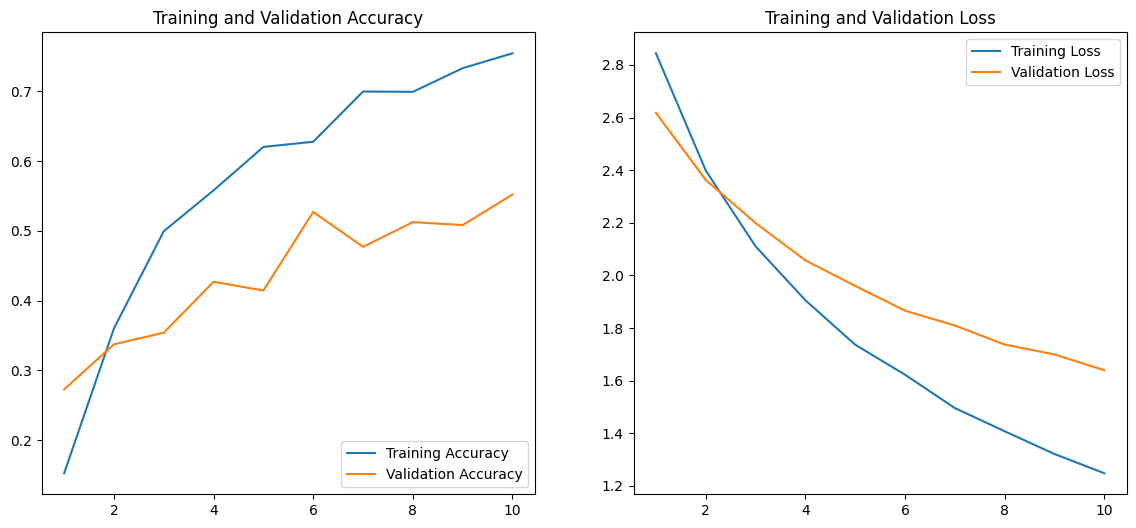

In [2]:
# 1. Import Library yang Dibutuhkan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 2. Definisikan Parameter dan Path Dataset
DATASET_PATH = '/kaggle/input/d/phiard/aksara-jawa/v3/v3'
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
VALIDATION_DIR = os.path.join(DATASET_PATH, 'val')  # Pastikan direktori validasi bernama 'val'

IMAGE_SIZE = (224, 224)
NUM_CLASSES = 20
EPOCHS = 10  # Sesuaikan dengan kebutuhan Anda
BATCH_SIZE = 32  # Tidak digunakan dalam pendekatan ini

# 3. Fungsi untuk Memuat Gambar dan Label
def load_data(directory, image_size, num_classes):
    data = []
    labels = []
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    print(f"\nMemuat data dari direktori: {directory}")
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                img = load_img(file_path, target_size=image_size)
                img_array = img_to_array(img) / 255.0  # Rescaling
                data.append(img_array)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f" - Gagal memuat gambar: {file_path}. Error: {e}")
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")
    print(f" - Total gambar dimuat: {len(data)}")
    return data, labels

# 4. Memuat Data Training dan Validasi ke dalam Numpy Arrays
X_train, y_train = load_data(TRAIN_DIR, IMAGE_SIZE, NUM_CLASSES)
X_val, y_val = load_data(VALIDATION_DIR, IMAGE_SIZE, NUM_CLASSES)

# 5. Mengubah Label ke Format Categorical
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)

print(f"\nShape X_train: {X_train.shape}")
print(f"Shape y_train_cat: {y_train_cat.shape}")
print(f"Shape X_val: {X_val.shape}")
print(f"Shape y_val_cat: {y_val_cat.shape}")

# 6. Bangun Model dengan Transfer Learning menggunakan ResNet-50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False  # Membekukan semua layer base_model

# Menambahkan layer baru di atas base_model
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Opsional: Tambahkan layer Dense tambahan jika diperlukan
# x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# 7. Kompilasi Model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate default
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Menambahkan Callback untuk Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 9. Melatih Model
history = model.fit(
    X_train,
    y_train_cat,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping],
    verbose=1  # Verbose level 1 untuk informasi pelatihan
)

# 10. Menyimpan Model
model.save('resnet50_transfer_learning_model.h5')
print("\nModel berhasil disimpan sebagai 'resnet50_transfer_learning_model.h5'.")

# 11. Evaluasi Model
loss, accuracy = model.evaluate(X_val, y_val_cat)
print(f'\nValidation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# 12. Menampilkan Grafik Training dan Validasi
def plot_training_history(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

# Memanggil fungsi untuk menampilkan grafik
plot_training_history(history)
